In [2]:
# Import required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,InputLayer
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf

In [4]:
# Import Sentiment140 dataset
# Update file location of Sentiment140.csv according to your working environment

data_path  = "data/training.1600000.processed.noemoticon.csv"

twitter_data = pd.read_csv(data_path,names=['target','id','date','flag','user','text'],
                           encoding = "ISO-8859-1")

In [5]:
# Create NumPy array of unprocessed input text and target 

X=np.array(twitter_data['text'])
Y=np.array(twitter_data['target'])

# Set Y=1 for Positive Tweets
Y[Y==4]=1

In [6]:
# Visualize Dataset

index = 123  # index in range [0,1599999]

print(X[index])

I am in pain. My back and sides hurt. Not to mention crying is made of fail. 


In [7]:
# Define Preprocessing functions

def tokenize(X):
  """
  Tokenize the data using nltk
  """

  treebank = nltk.tokenize.TreebankWordTokenizer()
  X_tokenized=[treebank.tokenize(sentence) for sentence in X]  
  return X_tokenized


def remove_stopwords(X):
  """
  Remove Stopwords using nltk
  """

  stopwords=nltk.corpus.stopwords.words('english') + ['@']
  X_without_stopwords = []

  for sentence in X:

    temp = [word for word in sentence if not word in stopwords]
    X_without_stopwords.append(temp) 

  return X_without_stopwords


def stem(X,type='porter'):
  """
  Perform Stemming using nltk
  type = 'Porter','Snowball','Lancaster'
  """
  
  if type == 'porter':
    stemmer= nltk.stem.PorterStemmer()
  elif type == 'snowball':
    stemmer = nltk.stem.SnowballStemmer()
  elif type == 'lancaster':
    stemmer = nltk.stem.LancasterStemmer()    

  
  X_stemmed = []

  for sentence in X:

    temp = [stemmer.stem(word) for word in sentence]
    X_stemmed.append(temp)

  return X_stemmed 



def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return 'a'
        elif treebank_tag.startswith('V'):
            return 'v'
        elif treebank_tag.startswith('N'):
            return 'n'
        elif treebank_tag.startswith('R'):
            return 'r'
        else:
            return 'n'


def lemmatize(X):
  """
  Lemmatize words using corresponding POS tag
  """

  lemmatizer = nltk.stem.WordNetLemmatizer()
  
  X_pos = []
  X_lemmatized = []

  for sentence in X :

    temp = nltk.pos_tag(sentence)
    X_pos.append(temp)  

  for sentence in X_pos :

    temp = [ lemmatizer.lemmatize(word[0],pos=get_wordnet_pos(word[1])) for word in sentence]
    X_lemmatized.append(temp)  

  return X_lemmatized    

# **Training on Pre-Processed data with GloVe Word Embeddings**



In [8]:
# Preprocess the data

X_tokenized = tokenize (X)

X_without_stopwords = remove_stopwords ( X_tokenized )

X_lemmatized = lemmatize ( X_without_stopwords )

X_clean = []

for sentence in X_lemmatized:

  temp = " ".join(sentence)
  X_clean.append(temp)

In [9]:
# Count total no. of distinct tokens

tokenizer = Tokenizer(filters='@')
tokenizer.fit_on_texts(X_clean)

print('No. of distinct tokens = '+str(len(tokenizer.word_index)))

No. of distinct tokens = 836890


In [10]:
# Define Vocabulary size (no. of most frequent tokens) to consider

max_vocab=50000

In [11]:
# Reload Twitter dataset with new Vocabulary

tokenizer = Tokenizer(num_words=max_vocab,filters='@')
tokenizer.fit_on_texts(X_clean)

In [12]:
# Vectorize input text using Vocabulary

X_clean_vectorized=tokenizer.texts_to_sequences(X_clean)

In [13]:
# Count average length of tweets

length=[]
for sentence in X_clean_vectorized:
  length.append(len(sentence))
  
print('Average length of tweets = '+str(np.mean(length)))

Average length of tweets = 10.061133125


In [14]:
# Define Maximum input length of the Model

max_length=20

In [15]:
# Pad or Trim data to defined input length

X_clean_pad = keras.preprocessing.sequence.pad_sequences(X_clean_vectorized,max_length,padding='post',
                                                         truncating='post')

print(X_clean_pad.shape)

(1600000, 20)


In [16]:
# Visualize pre-processed data

index  = 123  # index in range [0,1599999]

print('\nOriginal :')
print(X[index])
print('\nTokenized :')
print(X_tokenized[index])
print('\nStopwords removed :')
print(X_without_stopwords[index])
print('\nPOS tagged :')
print(nltk.pos_tag(X_without_stopwords[index]))
print('\nLemmatized :')
print(X_lemmatized[index])
print('\nClean :')
print(X_clean[index])
print('\nVectorized :')
print(X_clean_vectorized[index])
print('\nPadded :')
print(X_clean_pad[index])


Original :
I am in pain. My back and sides hurt. Not to mention crying is made of fail. 

Tokenized :
['I', 'am', 'in', 'pain.', 'My', 'back', 'and', 'sides', 'hurt.', 'Not', 'to', 'mention', 'crying', 'is', 'made', 'of', 'fail', '.']

Stopwords removed :
['I', 'pain.', 'My', 'back', 'sides', 'hurt.', 'Not', 'mention', 'crying', 'made', 'fail', '.']

POS tagged :
[('I', 'PRP'), ('pain.', 'VBP'), ('My', 'PRP$'), ('back', 'NN'), ('sides', 'NNS'), ('hurt.', 'VBP'), ('Not', 'RB'), ('mention', 'NN'), ('crying', 'VBG'), ('made', 'VBN'), ('fail', 'NN'), ('.', '.')]

Lemmatized :
['I', 'pain.', 'My', 'back', 'side', 'hurt.', 'Not', 'mention', 'cry', 'make', 'fail', '.']

Clean :
I pain. My back side hurt. Not mention cry make fail .

Vectorized :
[2, 3428, 62, 30, 591, 4229, 146, 831, 308, 33, 426, 4]

Padded :
[   2 3428   62   30  591 4229  146  831  308   33  426    4    0    0
    0    0    0    0    0    0]


In [16]:
# Load Pre-trained Word embeddings
# Update file location of glove.6B.100d.txt according to your working environment

embedding_path = './embedding/glove.twitter.27B.200d.txt'

embeddings_index = dict()
f = open(embedding_path, encoding='utf-8')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

In [17]:
# Create Word Embedding Matrix

embedding_matrix = np.zeros((max_vocab, 200))
for i in range(1,max_vocab):
	embedding_vector = embeddings_index.get(tokenizer.index_word[i])
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [18]:
# Define Classification model
# define model
model = tf.keras.models.Sequential()
model.add(InputLayer(input_shape=(20,),name='Integer_Encoding_after_Preprocessing'))
model.add(Embedding(max_vocab, 200, weights=[embedding_matrix], input_length=max_length,mask_zero=True,
                      name='Pretrained_GloVe_100D', trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(200, dropout = 0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation = "sigmoid"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Pretrained_GloVe_100D (Embed (None, 20, 200)           10000000  
_________________________________________________________________
dropout (Dropout)            (None, 20, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 64)                12864     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 10,333,729
Trainable params: 333,729
Non-trainable params: 10,000,000
_________________________________________________________________
None


In [19]:
# Model details

model.summary()
tf.keras.utils.plot_model(model,to_file='model.png')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Pretrained_GloVe_100D (Embed (None, 20, 200)           10000000  
_________________________________________________________________
dropout (Dropout)            (None, 20, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 64)                12864     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 10,333,729
Trainable params: 333,729
Non-trainable params: 10,000,000
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphvi

In [17]:
# Perform train-test split

np.random.seed(123)

X_train, X_test, Y_train, Y_test = train_test_split (X_clean_pad,Y.reshape(Y.shape[0],1),test_size=0.1)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1440000, 20)
(160000, 20)
(1440000, 1)
(160000, 1)


In [21]:
# Train the model
# Compile the Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from focal_loss import BinaryFocalLoss
model.compile(optimizer = "adam", loss = BinaryFocalLoss(gamma=2), metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('models/LSTM.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train,Y_train,batch_size=1024,epochs=25,validation_split=0.2,callbacks=[es, mc])

Epoch 1/25
1125/1125 [==============================] - 161s 139ms/step - loss: 0.1266 - accuracy: 0.7566 - val_loss: 0.1158 - val_accuracy: 0.7873

Epoch 00001: val_accuracy improved from -inf to 0.78733, saving model to models\LSTM.h5
Epoch 2/25
1125/1125 [==============================] - 169s 150ms/step - loss: 0.1182 - accuracy: 0.7805 - val_loss: 0.1122 - val_accuracy: 0.7958

Epoch 00002: val_accuracy improved from 0.78733 to 0.79584, saving model to models\LSTM.h5
Epoch 3/25
1125/1125 [==============================] - 173s 154ms/step - loss: 0.1150 - accuracy: 0.7884 - val_loss: 0.1101 - val_accuracy: 0.8010

Epoch 00003: val_accuracy improved from 0.79584 to 0.80101, saving model to models\LSTM.h5
Epoch 4/25
1125/1125 [==============================] - 170s 151ms/step - loss: 0.1128 - accuracy: 0.7939 - val_loss: 0.1093 - val_accuracy: 0.8024

Epoch 00004: val_accuracy improved from 0.80101 to 0.80235, saving model to models\LSTM.h5
Epoch 5/25
1125/1125 [=====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


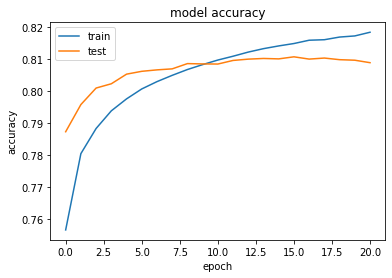

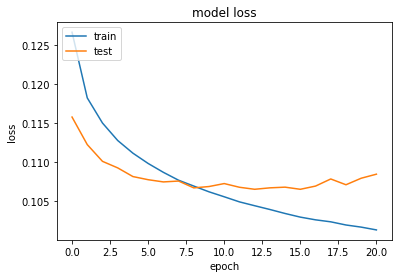

In [22]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Load and Evaluate

In [19]:
from focal_loss import BinaryFocalLoss
import tensorflow as tf    
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.models import load_model
model = load_model('models/LSTM.h5',custom_objects={'BinaryFocalLoss':BinaryFocalLoss})

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

yhat1 = model.predict(X_test, verbose=0)

#Binary Classification
yhat=np.where(yhat1 > 0.5, 1,0)

#Mutli-class Classification
#yhat = np.argmax(yhat, axis = 1)


accuracy = accuracy_score( Y_test, yhat)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(Y_test, yhat)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Y_test, yhat1)
print('ROC AUC: %f' % auc)


Accuracy: 0.808975
Precision: 0.801848
Recall: 0.820482
F1 score: 0.811058
Cohens kappa: 0.617955
ROC AUC: 0.893597


In [25]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [27]:
y_pred_1d = []
y_test_1d = list(Y_test)
scores = model.predict(X_test, verbose=1)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

5000/5000 [==============================] - 37s 7ms/step


In [28]:
y_test_1d = [decode_sentiment(score, include_neutral=False) for score in y_test_1d]

In [29]:
import itertools
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [30]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    labels=['Negative','Positive']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, labels, rotation=90, fontsize=22)
    plt.yticks(tick_marks, labels, fontsize=22)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

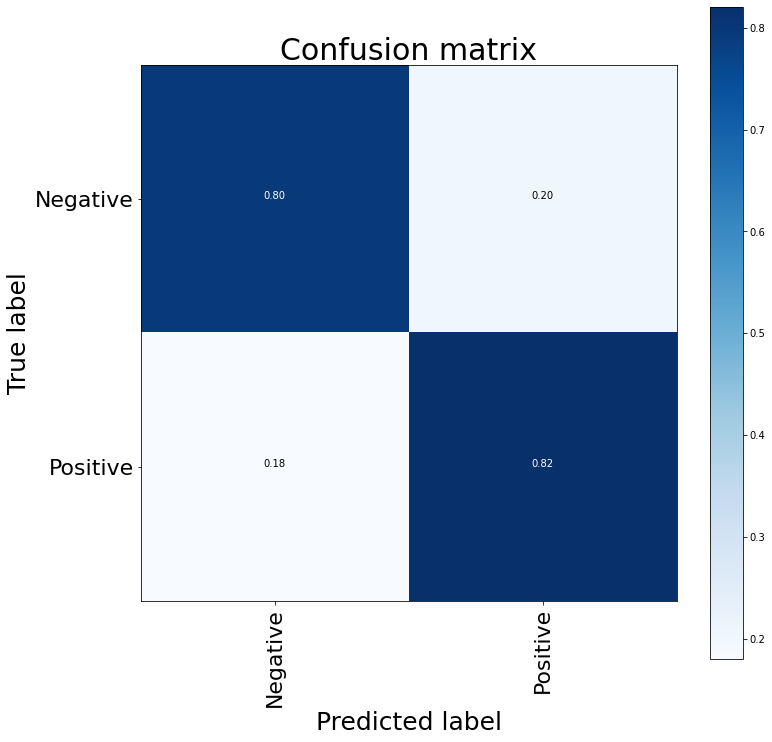

In [31]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=twitter_data.target.unique(), title="Confusion matrix")
plt.show()

In [32]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.82      0.80      0.81     80047
    POSITIVE       0.80      0.82      0.81     79953

    accuracy                           0.81    160000
   macro avg       0.81      0.81      0.81    160000
weighted avg       0.81      0.81      0.81    160000



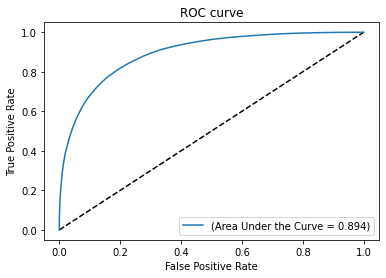

In [33]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='(Area Under the Curve = {:.3f})'.format(auc_keras))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ('ROC curve')
plt.legend(loc='best')
plt.show()

In [53]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, X_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:10],check_additivity=False)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [56]:
import numpy as np
words = tokenizer.word_index
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), X_test[i]))) for i in range(10)])

# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0])

In [58]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1], x_test_words[1])

In [60]:
shap.force_plot(explainer.expected_value[0], shap_values[0][3], x_test_words[3])

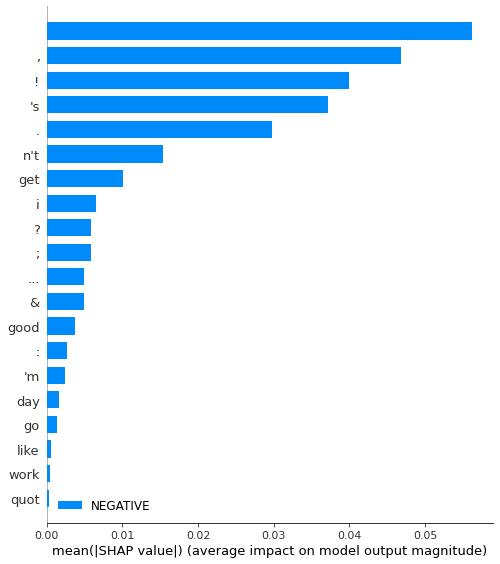

In [37]:
explainer2 = shap.DeepExplainer(model, X_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_vals = explainer2.shap_values(X_test[120:122],check_additivity=False)

selected_categories = ['NEGATIVE','POSITIVE']
words = tokenizer.word_index
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)
word_lookup = [''] + word_lookup
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=selected_categories)